In [1]:
import torch
torch.set_printoptions(linewidth=200, threshold=100000)

In [2]:
import sys
sys.path.append('/home/max/myrepos/vlstm_cuda/')
from plot_utils import plot_numerical_diffs_single

In [3]:
from ln import MultiHeadLayerNorm

from mlstm_parallel import mlstm_torch_autograd, mlstm_torch_ownbw, mlstm_triton

In [4]:
# params
S = 256 # seq len
B = 1 # batch size
NH = 1 # num heads
DH = 64 # dim per head
DTYPE = torch.float32
PT_AG_DTYPE = torch.float32
PT_OBW_DTYPE = torch.float32
TR_DTYPE = torch.float16
DEVICE = torch.device("cuda:0")
EPS = 0.0

In [5]:
# create qkv, inputgates, forgetgates 
torch.manual_seed(1)
qs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
ks = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
vs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
igs = torch.rand((B, NH, S), device=DEVICE, dtype=DTYPE)
igs2 = (1. + torch.arange((B * NH * S), device=DEVICE, dtype=DTYPE)).reshape(B, NH, S)
fgs = torch.rand((B, NH, S), device=DEVICE, dtype=DTYPE)
qs.shape, fgs.shape

(torch.Size([1, 1, 256, 64]), torch.Size([1, 1, 256]))

In [6]:
offset = 3.* torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)

In [7]:
mh_layernorm = MultiHeadLayerNorm(NH*DH, eps=1e-6).to(device=DEVICE, dtype=DTYPE)
mh_layernorm.weight, mh_layernorm.bias

(Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        device='cuda:0', requires_grad=True),
 None)

## pytorch

In [8]:
fgs_pt = fgs.clone().to(PT_AG_DTYPE).detach().requires_grad_(True)
igs_pt = igs.clone().to(PT_AG_DTYPE).detach().requires_grad_(True)
qs_pt = qs.clone().to(PT_AG_DTYPE).detach().requires_grad_(True)
ks_pt = ks.clone().to(PT_AG_DTYPE).detach().requires_grad_(True)
vs_pt = vs.clone().to(PT_AG_DTYPE).detach().requires_grad_(True)

In [9]:
qs_pt.grad

In [10]:
hs_pt = mlstm_torch_autograd(qs_pt, ks_pt, vs_pt, igs_pt, fgs_pt)
hs_pt_scaled = mh_layernorm(hs_pt)

In [11]:
((hs_pt_scaled+offset)**2).sum().backward()

## own backward torch

In [12]:
fgs_obw = fgs.clone().to(PT_OBW_DTYPE).detach().requires_grad_(True)
igs_obw = igs.clone().to(PT_OBW_DTYPE).detach().requires_grad_(True)
qs_obw = qs.clone().to(PT_OBW_DTYPE).detach().requires_grad_(True)
ks_obw = ks.clone().to(PT_OBW_DTYPE).detach().requires_grad_(True)
vs_obw = vs.clone().to(PT_OBW_DTYPE).detach().requires_grad_(True)

In [13]:
hs_obw = mlstm_torch_ownbw(qs_obw, ks_obw, vs_obw, igs_obw, fgs_obw)
hs_obw_scaled = mh_layernorm(hs_obw)

In [14]:
((hs_obw_scaled+offset)**2).sum().backward()

In [15]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"====== PT Autograd -> PT Own backward ======")
print(f"dQ match: {torch.allclose(qs_pt.grad.float(), qs_obw.grad.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(qs_pt.grad - qs_obw.grad))}")
print(f"dK match: {torch.allclose(ks_pt.grad.float(), ks_obw.grad.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(ks_pt.grad - ks_obw.grad))}")
print(f"dV match: {torch.allclose(vs_pt.grad.float(), vs_obw.grad.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(vs_pt.grad - vs_obw.grad))}")
print(f"dI match: {torch.allclose(igs_pt.grad.float(), igs_obw.grad.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(igs_pt.grad - igs_obw.grad))}")
print(f"dF match: {torch.allclose(fgs_pt.grad.float(), fgs_obw.grad.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(fgs_pt.grad - fgs_obw.grad))}")

====== PT Autograd -> PT Own backward ======
dQ match: False, max diff: 0.00029349327087402344
dK match: False, max diff: 0.00022935867309570312
dV match: True, max diff: 3.814697265625e-06
dI match: False, max diff: 0.000743865966796875
dF match: False, max diff: 0.00032806396484375


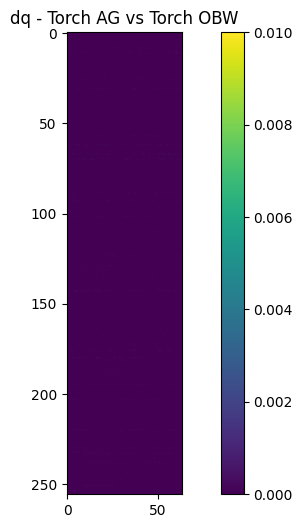

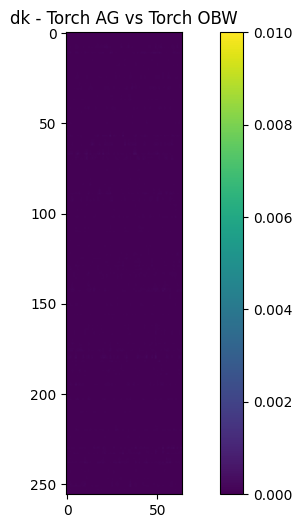

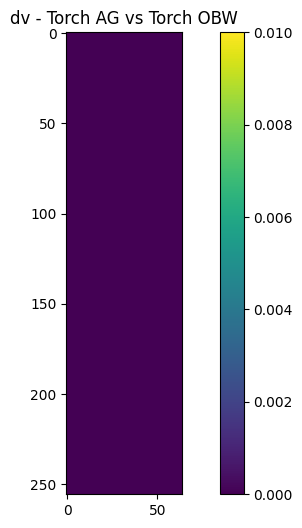

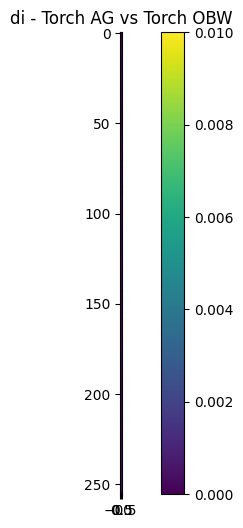

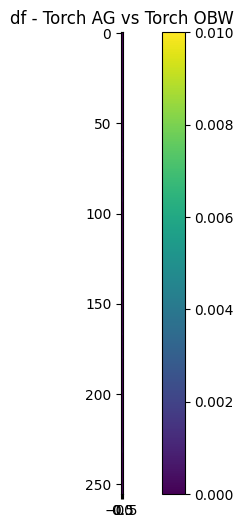

In [16]:
vmax = 0.01
fig = plot_numerical_diffs_single(qs_pt.grad, qs_obw.grad, "dq - Torch AG vs Torch OBW", vmax=vmax)
fig = plot_numerical_diffs_single(ks_pt.grad, ks_obw.grad, "dk - Torch AG vs Torch OBW", vmax=vmax)
fig = plot_numerical_diffs_single(vs_pt.grad, vs_obw.grad, "dv - Torch AG vs Torch OBW", vmax=vmax)
fig = plot_numerical_diffs_single(igs_pt.grad, igs_obw.grad, "di - Torch AG vs Torch OBW", vmax=vmax)
fig = plot_numerical_diffs_single(fgs_pt.grad, fgs_obw.grad, "df - Torch AG vs Torch OBW", vmax=vmax)

## triton

In [17]:
import triton
triton.runtime.driver.active.get_current_target()

GPUTarget(backend='cuda', arch=89, warp_size=32)

In [18]:
fgs_tr = fgs.clone().to(TR_DTYPE).detach().requires_grad_(True)
igs_tr = igs.clone().to(TR_DTYPE).detach().requires_grad_(True)
qs_tr = qs.clone().to(TR_DTYPE).detach().requires_grad_(True)
ks_tr = ks.clone().to(TR_DTYPE).detach().requires_grad_(True)
vs_tr = vs.clone().to(TR_DTYPE).detach().requires_grad_(True)

In [19]:
hs_tr = mlstm_triton(qs_tr, ks_tr, vs_tr, igs_tr, fgs_tr)
hs_tr_scaled = mh_layernorm(hs_tr)

In [20]:
hs_tr_scaled.max()

tensor(3.7734, device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>)

In [21]:
print(f"hs match: {torch.allclose(hs_pt_scaled.float(), hs_tr_scaled.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_scaled - hs_tr_scaled))}")


hs match: False, max diff: 0.008412718772888184


In [29]:
hs_tr.shape

torch.Size([1, 1, 256, 64])

In [23]:
((hs_tr_scaled+offset)**2).sum().backward()

In [24]:
hs_tr_scaled.max()

tensor(3.7734, device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>)

In [25]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"====== Triton -> PT Autograd ======")
print(f"hs match: {torch.allclose(hs_pt_scaled.float(), hs_tr_scaled.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_scaled - hs_tr_scaled))}")
print(f"dQ match: {torch.allclose(qs_pt.grad.float(), qs_tr.grad.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(qs_pt.grad - qs_tr.grad))}")
print(f"dK match: {torch.allclose(ks_pt.grad.float(), ks_tr.grad.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(ks_pt.grad - ks_tr.grad))}")
print(f"dV match: {torch.allclose(vs_pt.grad.float(), vs_tr.grad.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(vs_pt.grad - vs_tr.grad))}")
print(f"dI match: {torch.allclose(igs_pt.grad.float(), igs_tr.grad.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(igs_pt.grad - igs_tr.grad))}")
print(f"dF match: {torch.allclose(fgs_pt.grad.float(), fgs_tr.grad.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(fgs_pt.grad - fgs_tr.grad))}")

print(f" ====== Triton -> PT Own backward ======")
print(f"hs match: {torch.allclose(hs_obw_scaled.float(), hs_tr_scaled.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_obw_scaled - hs_tr_scaled))}")
print(f"dQ match: {torch.allclose(qs_obw.grad.float(), qs_tr.grad.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(qs_obw.grad - qs_tr.grad))}")
print(f"dK match: {torch.allclose(ks_obw.grad.float(), ks_tr.grad.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(ks_obw.grad - ks_tr.grad))}")
print(f"dV match: {torch.allclose(vs_obw.grad.float(), vs_tr.grad.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(vs_obw.grad - vs_tr.grad))}")
print(f"dI match: {torch.allclose(igs_obw.grad.float(), igs_tr.grad.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(igs_obw.grad - igs_tr.grad))}")
print(f"dF match: {torch.allclose(fgs_obw.grad.float(), fgs_tr.grad.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(fgs_obw.grad - fgs_tr.grad))}")

====== Triton -> PT Autograd ======
hs match: False, max diff: 0.008412718772888184
dQ match: False, max diff: 0.30786895751953125
dK match: False, max diff: 0.24111175537109375
dV match: False, max diff: 0.03338479995727539
dI match: False, max diff: 0.17911529541015625
dF match: False, max diff: 0.10850143432617188
 ====== Triton -> PT Own backward ======
hs match: False, max diff: 0.008412718772888184
dQ match: False, max diff: 0.30786895751953125
dK match: False, max diff: 0.2411041259765625
dV match: False, max diff: 0.033383846282958984
dI match: False, max diff: 0.1794586181640625
dF match: False, max diff: 0.10846734046936035


In [26]:
# S=256, DH=64
# # Baseline in float32
# ====== Triton -> PT Autograd ======
# hs match: False, max diff: 0.008412718772888184
# dQ match: False, max diff: 0.30786895751953125
# dK match: False, max diff: 0.24111175537109375
# dV match: False, max diff: 0.03338479995727539
# dI match: False, max diff: 0.17911529541015625
# dF match: False, max diff: 0.10850143432617188
#  ====== Triton -> PT Own backward ======
# hs match: False, max diff: 0.008412718772888184
# dQ match: False, max diff: 0.30786895751953125
# dK match: False, max diff: 0.2411041259765625
# dV match: False, max diff: 0.033383846282958984
# dI match: False, max diff: 0.1794586181640625
# dF match: False, max diff: 0.10846734046936035

# Baseline in float16
# float16:
# ====== Triton -> PT Autograd ======
# hs match: False, max diff: 0.0029296875
# dQ match: False, max diff: 0.125
# dK match: False, max diff: 0.09375
# dV match: False, max diff: 0.03125
# dI match: False, max diff: 0.125
# dF match: False, max diff: 0.15625
#  ====== Triton -> PT Own backward ======
# hs match: False, max diff: 0.0029296875
# dQ match: False, max diff: 0.125
# dK match: False, max diff: 0.09375
# dV match: False, max diff: 0.03125
# dI match: False, max diff: 0.09375
# dF match: False, max diff: 0.234375

# # bfloat16:
# ====== Triton -> PT Autograd ======
# hs match: False, max diff: 1.42138671875
# dQ match: False, max diff: 50.625
# dK match: False, max diff: 47.28125
# dV match: False, max diff: 13.296875
# dI match: False, max diff: 15.1875
# dF match: False, max diff: 7.6640625
#  ====== Triton -> PT Own backward ======
# hs match: False, max diff: 1.42138671875
# dQ match: False, max diff: 50.625
# dK match: False, max diff: 47.28125
# dV match: False, max diff: 13.296875
# dI match: False, max diff: 15.15625
# dF match: False, max diff: 7.8125

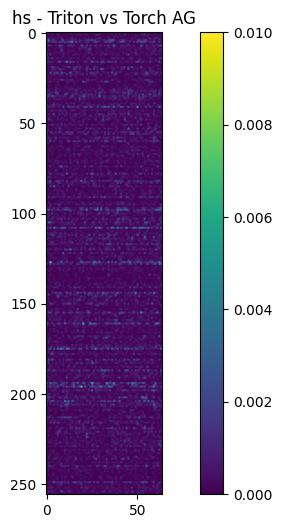

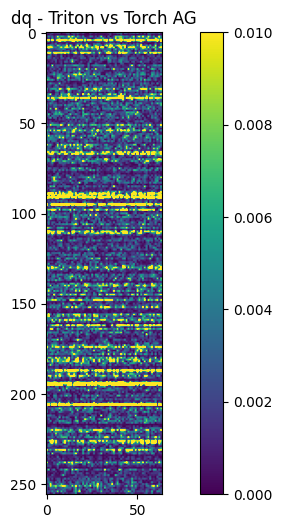

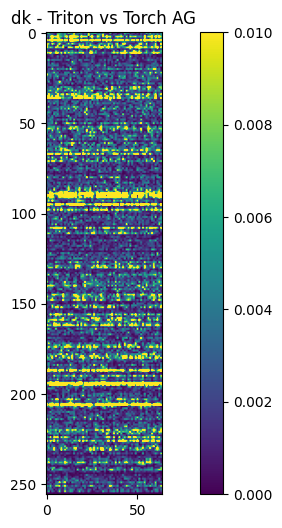

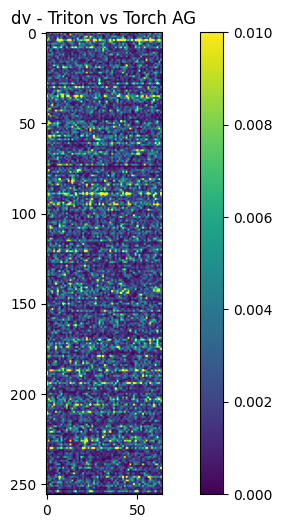

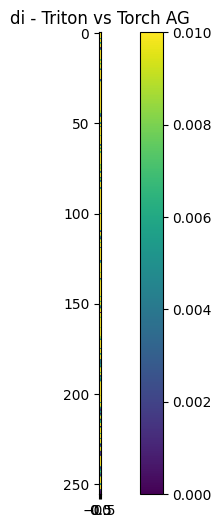

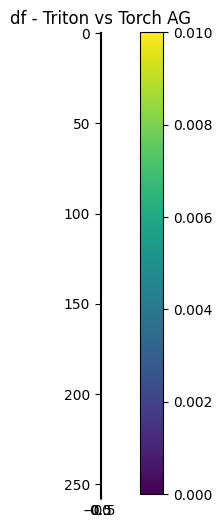

In [27]:
# Triton -> PT Autograd
vmax = 0.01
fig = plot_numerical_diffs_single(hs_tr.detach(), hs_pt.detach(), "hs - Triton vs Torch AG", vmax=vmax)
fig = plot_numerical_diffs_single(qs_tr.grad, qs_pt.grad, "dq - Triton vs Torch AG", vmax=vmax)
fig = plot_numerical_diffs_single(ks_tr.grad, ks_pt.grad, "dk - Triton vs Torch AG", vmax=vmax)
fig = plot_numerical_diffs_single(vs_tr.grad, vs_pt.grad, "dv - Triton vs Torch AG", vmax=vmax)
fig = plot_numerical_diffs_single(igs_tr.grad, igs_pt.grad, "di - Triton vs Torch AG", vmax=vmax)
fig = plot_numerical_diffs_single(fgs_tr.grad, fgs_pt.grad, "df - Triton vs Torch AG", vmax=vmax)

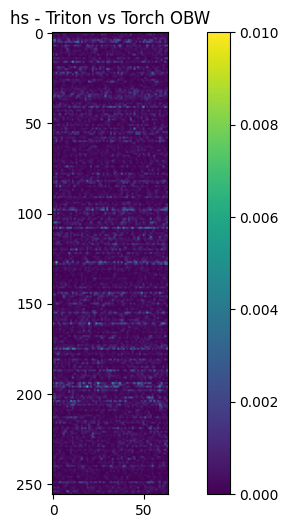

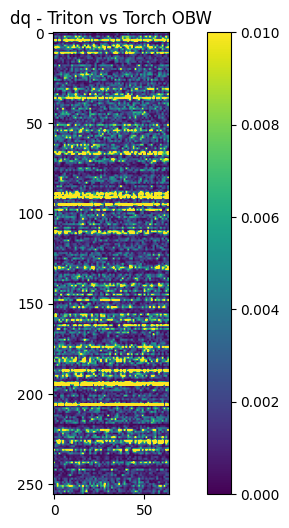

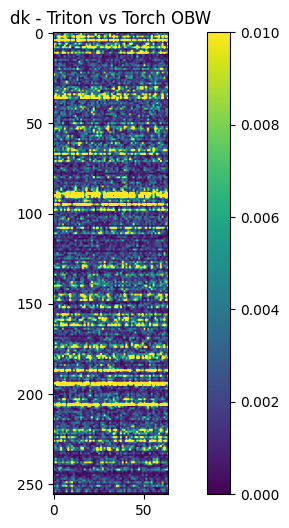

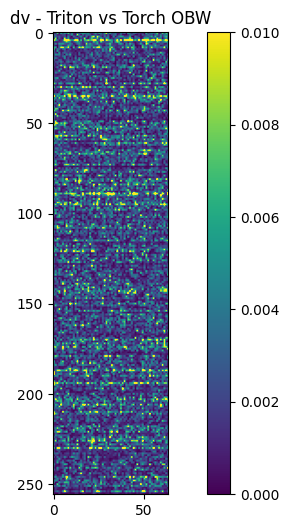

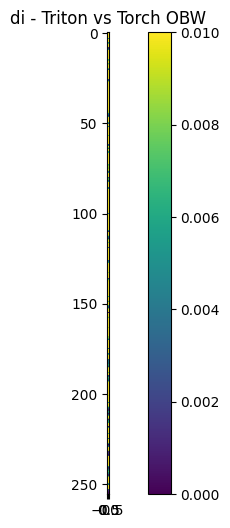

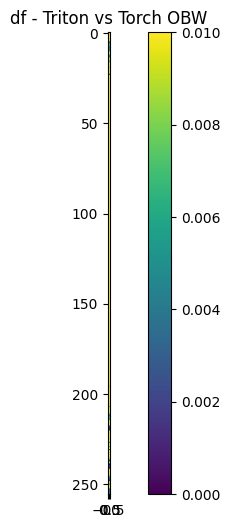

In [28]:
# Triton -> PT OBW
vmax = 0.01
fig = plot_numerical_diffs_single(hs_tr.detach(), hs_obw.detach(), "hs - Triton vs Torch OBW", vmax=vmax)
fig = plot_numerical_diffs_single(qs_tr.grad, qs_obw.grad, "dq - Triton vs Torch OBW", vmax=vmax)
fig = plot_numerical_diffs_single(ks_tr.grad, ks_obw.grad, "dk - Triton vs Torch OBW", vmax=vmax)
fig = plot_numerical_diffs_single(vs_tr.grad, vs_obw.grad, "dv - Triton vs Torch OBW", vmax=vmax)
fig = plot_numerical_diffs_single(igs_tr.grad, igs_obw.grad, "di - Triton vs Torch OBW", vmax=vmax)
fig = plot_numerical_diffs_single(fgs_tr.grad, fgs_obw.grad, "df - Triton vs Torch OBW", vmax=vmax)